# # Chien luoc MA, ATR cho FOREX: Connect den SQL Server

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ConnectSQL
import ConnectSQLAlChemy

# Tải dữ liệu EUR/USD
symbol = "EURUSD=X"
start_date = "2022-01-01"
end_date = "2023-11-27"

# Tạo đối tượng từ class ConnectSQL với thông tin kết nối cụ thể của bạn
conn = ConnectSQLAlChemy.ConnectSQLAlChemy(server='.', 
                  database='Cole', 
                  username='sa', 
                  password='1')
# Kết nối tới cơ sở dữ liệu
conn.connect()

# Tạo câu lệnh SQL với tham số
sql_query = 'SELECT * FROM Trading_Data_Forex WHERE [Datetime] >= \'' + start_date + '\' AND [Datetime] <= \'' + end_date + '\'' + ' Order by Datetime asc'

print(sql_query)

# Lấy dữ liệu từ cơ sở dữ liệu
ohlcv = conn.get_data(sql_query)
data = pd.DataFrame(ohlcv, columns=['Datetime','Open', 'High', 'Low', 'Close', 'Volume'])

# Tính toán chỉ báo MA và ATR
ma_fast_period = 50
ma_slow_period = 200
atr_period = 14
atr_threshold = 0.009  # Giả sử ngưỡng ATR cho EUR/USD

data['MA_Fast'] = data['Close'].rolling(window=ma_fast_period).mean()
data['MA_Slow'] = data['Close'].rolling(window=ma_slow_period).mean()
data['TR'] = data['High'] - data['Low']
data['ATR'] = data['TR'].rolling(window=atr_period).mean()

# Xác định tín hiệu mua
data['Signal'] = np.where((data['MA_Fast'] > data['MA_Slow']) & (data['ATR'] <= atr_threshold), 1, 0)
data['Position'] = data['Signal'].shift()

# Các tham số cho giao dịch Forex
initial_capital = 1000000  # Vốn ban đầu
lot_size = 100000  # Kích thước của một standard lot (ví dụ: 100,000 EUR cho EUR/USD)
leverage = 1  # Giả sử sử dụng đòn bẩy 1:1
lot_per_signal = 0.01  # Số lot giao dịch mỗi tín hiệu
lots_bought = 0

data['Capital'] = initial_capital
data['Capital'] = data['Capital'].astype(float)

data['Lots_Bought'] = 0
data['Lots_Bought'] = data['Lots_Bought'].astype(float)

# Điều chỉnh mô phỏng giao dịch và theo dõi số lot mua
current_capital = initial_capital  # Biến mới để theo dõi vốn hiện tại

for index, row in data.iterrows():
    if row['Position'] == 1:
        trade_value = row['Close'] * lot_size * lot_per_signal  # Giá trị giao dịch dựa vào giá đóng cửa
        required_margin = trade_value / leverage
        if required_margin <= current_capital:
            current_capital -= required_margin
            data.at[index, 'Capital'] = current_capital
            lots_bought += lot_per_signal  # Tăng số lot mua
            data.at[index, 'Lots_Bought'] = lots_bought
    else:
        data.at[index, 'Capital'] = current_capital
        data.at[index, 'Lots_Bought'] = lots_bought

    current_value = current_capital + lots_bought * lot_size * row['Close']

data.to_csv('Buoi 9.3 Thuc hanh 1-2-3-4 MA, ATR Forex 1.csv')
# Tìm chỉ mục của ngày vào lệnh đầu tiên
first_entry_index = data[data['Position'] == 1].index.min()

# Truy xuất ngày vào lệnh đầu tiên từ chỉ mục
first_entry_date = data.loc[first_entry_index, 'Datetime']

# Tính lợi nhuận
profit = current_value - initial_capital

print(f"Ngày vào lệnh đầu tiên: {first_entry_date}")
print(f'Tổng lợi nhuận: {profit}')
print(f'Tổng giá trị tài khoản: {current_value}')

Kết nối thành công
SELECT * FROM Trading_Data_Forex WHERE [Datetime] >= '2022-01-01' AND [Datetime] <= '2023-11-27' Order by Datetime asc
Ngày vào lệnh đầu tiên: 2023-01-02 00:00:00
Tổng lợi nhuận: 1281.5068960190983
Tổng giá trị tài khoản: 1001281.5068960191


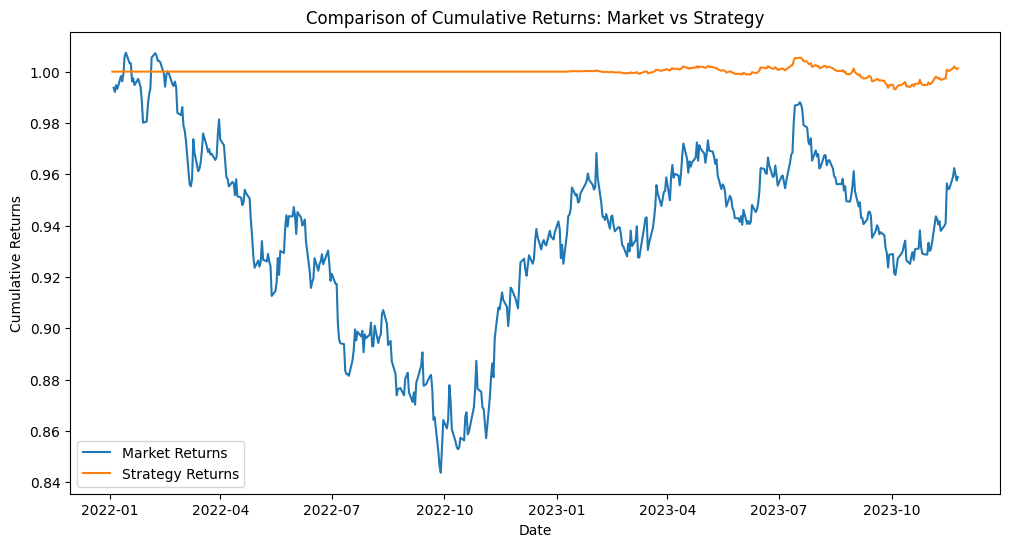

In [5]:
data.set_index('Datetime', inplace=True)

# Tính lợi nhuận lũy kế từ thị trường
data['Market_Return'] = data['Close'].pct_change()
data['Cumulative_Market_Returns'] = (1 + data['Market_Return']).cumprod()
# Tính lợi nhuận lũy kế từ chiến lược
data['Strategy_Value'] = data['Capital'] + data['Lots_Bought'] * lot_size * data['Close']
data['Cumulative_Strategy_Returns'] = data['Strategy_Value'] / initial_capital
data.to_csv('Buoi 9.3 Thuc hanh 1-2-3-4 MA, ATR Forex 2.csv')

# Vẽ biểu đồ so sánh lợi nhuận lũy kế từ thị trường và từ chiến lược
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Market_Returns'], label='Market Returns')
plt.plot(data['Cumulative_Strategy_Returns'], label='Strategy Returns')
plt.title('Comparison of Cumulative Returns: Market vs Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()